# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)). 
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

---

Note to instructors: `((Link doesn't Work))` [new Link](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

In [2]:
from torchvision import datasets, models

In [21]:
# transforms
train_transform = transforms.Compose([ transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([ transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Create training/test set training/test dataloader
training_set = datasets.CIFAR10('root', train = True ,transform = train_transform, download = True)
training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
test_set = datasets.CIFAR10('root', train = False ,transform = test_transform, download = True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [22]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Number of training images: 1563
Number of test images: 313
Image size: 224x224
deer


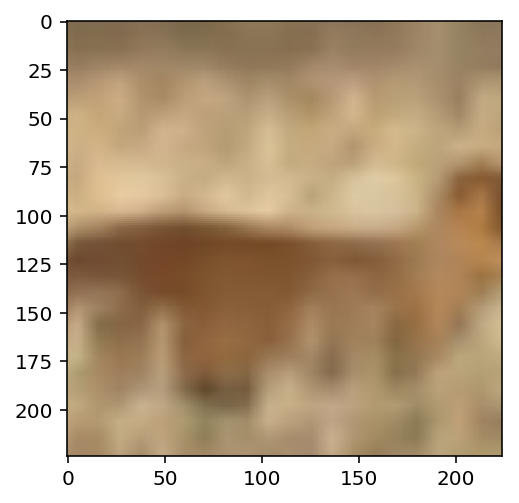

horse


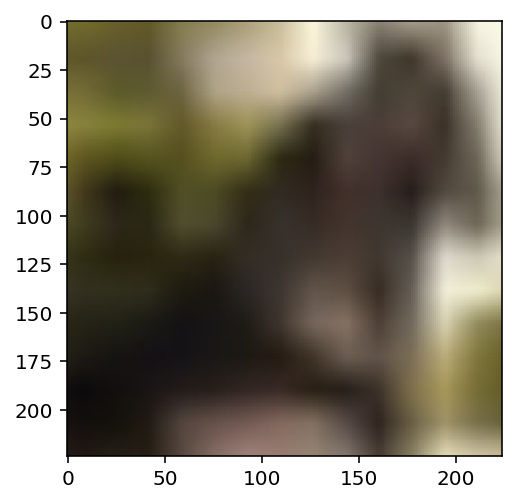

cat


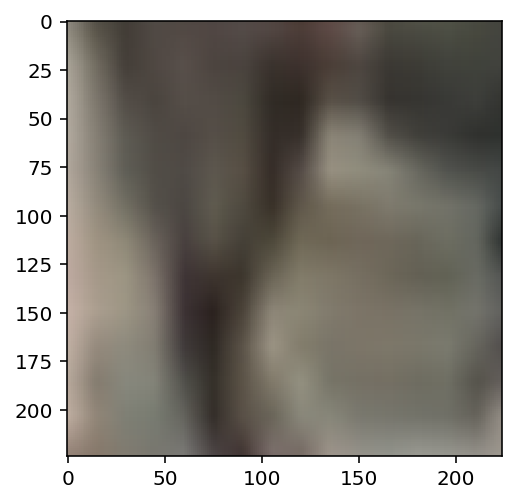

plane


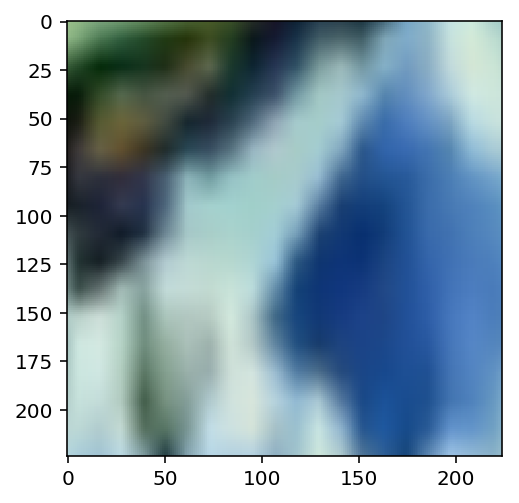

bird


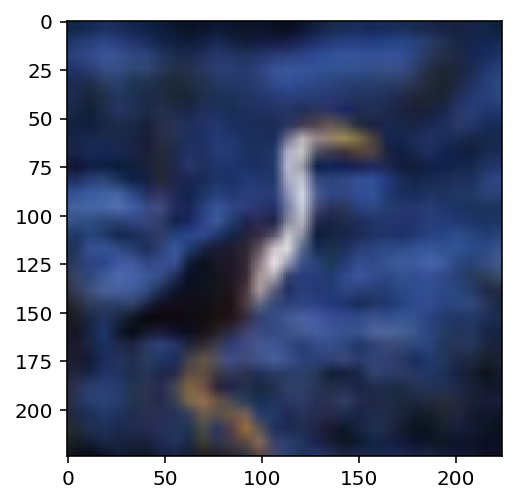

In [23]:
# Explore data
print(f'Number of training images: {len(training_dataloader)}')
print(f'Number of test images: {len(test_dataloader)}')
print(f'Image size: {next(iter(training_dataloader))[0][0].size(1)}x{next(iter(training_dataloader))[0][0].size(2)}')
show5(training_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [24]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(256, 10),
                          nn.LogSoftmax(dim=1))

model.fc = classifier


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [25]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batches = 250
steps = 0
running_loss = 0
epochs = 2
train_losses, test_losses = [], []

for epoch in range(epochs):
    for img, label in training_dataloader:
        steps += 1
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(img)     
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % batches == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for img, label in test_dataloader:
                    img, label = img.to(device), label.to(device)
                    output = model.forward(img)
                    loss = criterion(output, label)
                    test_loss += loss.item()
                    
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_losses.append(running_loss/batches)
            test_losses.append(test_loss/len(test_dataloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/batches:.3f}.. "
                  f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_dataloader):.3f}")
            running_loss = 0
            model.train()
print('Training Done.')

Epoch 1/2.. Train loss: 1.929.. Test loss: 1.509.. Test accuracy: 0.396
Epoch 1/2.. Train loss: 1.686.. Test loss: 1.365.. Test accuracy: 0.470
Epoch 1/2.. Train loss: 1.646.. Test loss: 1.256.. Test accuracy: 0.527
Epoch 1/2.. Train loss: 1.581.. Test loss: 1.128.. Test accuracy: 0.614
Epoch 1/2.. Train loss: 1.553.. Test loss: 1.091.. Test accuracy: 0.602
Epoch 1/2.. Train loss: 1.536.. Test loss: 1.161.. Test accuracy: 0.596
Epoch 2/2.. Train loss: 1.516.. Test loss: 1.100.. Test accuracy: 0.654
Epoch 2/2.. Train loss: 1.496.. Test loss: 1.005.. Test accuracy: 0.699
Epoch 2/2.. Train loss: 1.519.. Test loss: 0.963.. Test accuracy: 0.661
Epoch 2/2.. Train loss: 1.491.. Test loss: 0.970.. Test accuracy: 0.680
Epoch 2/2.. Train loss: 1.470.. Test loss: 0.991.. Test accuracy: 0.674
Epoch 2/2.. Train loss: 1.476.. Test loss: 1.026.. Test accuracy: 0.628
Training Done.


Plot the training loss (and validation loss/accuracy, if recorded).

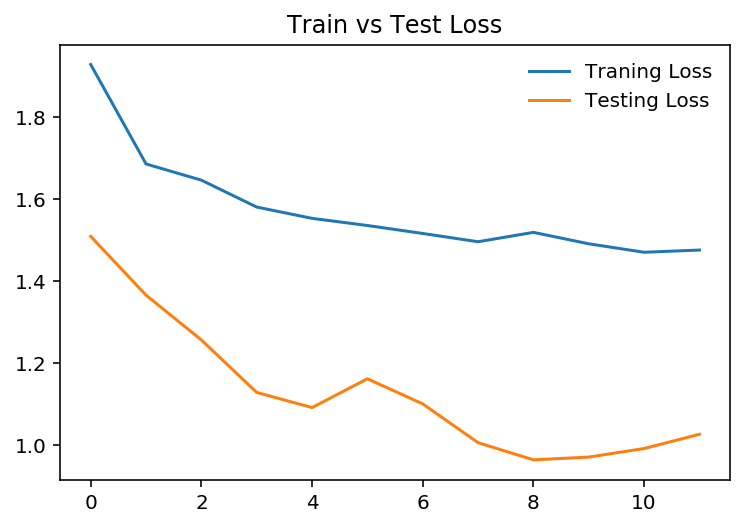

In [59]:
plt.plot(train_losses, label="Traning Loss")
plt.plot(test_losses, label="Testing Loss")
plt.legend(frameon=False)
plt.title('Train vs Test Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [70]:
model.eval()
true_pred = {classname: 0 for classname in classes}
total = {classname: 0 for classname in classes}

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model.forward(imgs)
        _, predicts = torch.max(output, 1)
        for label, predict in zip(labels, predicts):
            if label == predict:
                true_pred[classes[label]] += 1
            total[classes[label]] += 1

suma = 0
print("Accuracy:")
for classname, t in true_pred.items():
    accuracy = 100 * float(t) / total[classname]
    suma += accuracy
    print(f"• Class {classname}: %{accuracy:.1f}")
print(f"Overall Accuracy: %{(suma / len(classes)):.1f}")

Accuracy:
• Class plane: %63.5
• Class car: %65.7
• Class bird: %58.9
• Class cat: %28.9
• Class deer: %74.3
• Class dog: %81.8
• Class frog: %84.1
• Class horse: %69.2
• Class ship: %66.5
• Class truck: %90.7
Overall Accuracy: %68.4


## Saving your model
Using `torch.save`, save your model for future loading.

In [71]:
torch.save(model.state_dict(), 'model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

In my opinion, building is more efficient than buying. The overall accuracy was %68.4 compared to Detectocorp's model, which was %70 My model was less by %1.6, but that was just for 2 epochs.

I believe if I increase the epoch to 10 or 100, the accuracy will increase as well, reaching up to %90. Unfortunately, the GPU time is up and training data for one epoch takes approx. 1 hour.

So to achieve more accuracy, we have to build our model in the right way, increase the number of epochs, and train.

To get better results, yes, we have to improve our accuracy. Like I said before, to improve the model we have to train it more and more.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).

[Train your model](https://docs.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model)
[Deep Learning Exercises](https://learn.udacity.com/nanodegrees/nd229/parts/cd0420/lessons/5b3194d7-979c-43c2-b0b5-48dadfd20dd5/concepts/827be718-37d4-497b-b298-297909a2641a)